In [100]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda
from torch.nn import functional as F
from scipy import io as sio

In [101]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datasets

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [108]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # I have chosen not to use RandomResizeCrop as it can remove large parts of the flowers
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # These are the values used for ImageNet
    # transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[0.0, 0.0, 0.0])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    # transforms.Normalize(mean=[0.4330, 0.3819, 0.2964],std=[0.2588, 0.2094, 0.2212])
])
valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [109]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='flowers102',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='flowers102',
    split="val",
    download=True,
    transform=valid_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='flowers102',
    split="test",
    download=True,
    transform=test_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# Get the targets and ids
image_labels = sio.loadmat("flowers102/flowers-102/imagelabels")
setids = sio.loadmat("flowers102/flowers-102/setid")
print(np.unique(image_labels['labels']).size)
train_ids = setids['trnid']

102


In [110]:
image, label = train_dataset[9]
label

0

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cpu


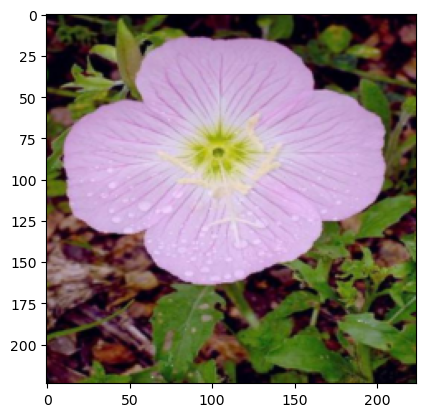

In [117]:
# look at the first training sample
image, label = train_dataset[8]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))

In [113]:
mean = 0.0
std = 0.0
for img, _ in train_dataset:
    mean += img.mean([1, 2])
    std += img.std([1, 2])
mean /= len(train_dataset)
std /= len(train_dataset)
print(f"Mean: {mean} +/- {std}")

Mean: tensor([0.4330, 0.3819, 0.2964]) +/- tensor([0.2588, 0.2094, 0.2212])


In [114]:
trans = transforms.Compose([
        transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    ])
for img, _ in train_dataset:
    img = trans(img)

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cpu


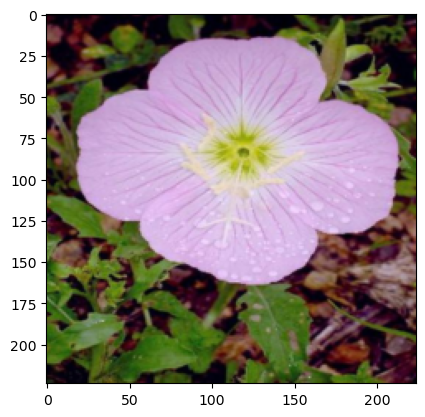

In [116]:
image, label = train_dataset[8]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))